# Final Project: DBSCAN Clustering-Karsen Diepholz

# Abstract

This semester has been one of the most exciting for me. I had expected to be "Data Mining" to be boring, and honestly, just another class to get through in college. However, this was not the case at all. All of the homeworks and methods and methodology we used in class were extremely interesting. The most interesting were the clustering algorithms that we studied, and that is what I have implemented into this project. Much of my interest in data mining lies within the financial world (much like you Professor J) and clustering is a big part of that. A lot of my research focused on the best ways to cluster large amounts of data. A lot of algorithms failed after having a certain number of data, say 100,000 or 1 million. If I had a larger or better computer (with over 100gb of RAM), I would love to perform these same tests, except with all of the data

# Overview

Problem Statement: Create a method to divide the trained data into clusters.

Method: Compute DBSCAN on a trained dataset to move it into clusters, then put each cluster through a pipeline with a Decision Tree Classifier. After finding the highest accuracy, that cluster will be put through the final pipeline with a SGDRegressor(see below for reasoning why).

In [3]:
import os

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.datasets import load_iris

from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn2pmml.decoration import ContinuousDomain
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn_pandas import DataFrameMapper
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import preprocessing



from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn

import onnxruntime as rt

from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

import graphviz
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns

First we must import the data and create a training model, this is self-explanitory

In [4]:
data = pd.read_csv('data_public.csv')

In [5]:
data.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,31.628960,-4.925617,29.828238,-5.572780,20.129709,7.072373,19.335662,27.283873,9.375416,15.336531,34.086952,-3.845316,-4.195369,18.972837,21.279968,3
1,-24.878420,-12.140354,-0.638120,6.712182,-18.044057,-12.485812,-5.060765,-23.392410,-9.336210,6.583095,-2.530664,-3.626419,-35.546821,-11.784902,-4.100635,2
2,-25.711262,-16.540789,7.450853,4.941910,-18.273375,-13.062138,-7.082651,-17.443779,-8.103270,8.345905,-1.319908,-1.234682,-33.845745,-6.827543,-5.758754,2
3,27.837458,-2.436980,29.479857,-3.360867,14.997228,10.254915,10.530714,27.082219,9.254091,26.860616,29.592860,-2.926678,-4.497271,15.949510,19.642792,3
4,30.520663,-5.017300,24.798154,-4.668743,19.697230,12.570798,13.141632,31.598069,12.120745,16.478925,25.257392,-2.133821,-4.365376,21.024188,18.976706,3


# Data Process and Analysis

I chose to do a 75/25 split on my data, meaning that the first 75% of the data would be taken as the training for the data, and the next 25% would be used for testing on my data.

In [6]:
X=pd.DataFrame(data.drop('Class',axis=1),columns=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O'])
y=pd.DataFrame(data['Class'],columns=['Class'])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25)

In [16]:
X_train.shape[1]

15

In [8]:
X_test

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
699869,-25.857539,-12.188460,-0.607263,6.543077,-19.298725,-17.362518,-4.289099,-21.726440,-7.729512,4.375480,-4.498205,-1.619818,-34.255997,-9.357236,-2.406480
450195,-22.318857,-11.278259,1.003786,7.249974,-19.751845,-19.091060,-3.462846,-21.537013,-9.762448,8.128171,-4.042841,-4.973600,-30.205227,-11.131159,-4.579316
89822,-20.274476,-12.024322,0.526766,5.984459,-16.429320,-17.766048,-1.355910,-19.417458,-9.734463,12.145606,-2.370190,-4.745405,-31.582176,-7.928693,-3.306669
1041952,-25.442455,-13.395499,-0.059890,6.824031,-16.851119,-18.323620,-2.381520,-16.962051,-7.944411,5.383314,-7.232154,-2.346272,-33.948215,-7.449262,-4.944954
289647,-1.802507,-2.253169,2.550142,-12.750435,7.714916,-14.980624,-3.685992,9.258986,19.456676,-7.583488,14.451524,1.930888,-1.195806,17.569696,23.938255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403170,28.973563,-2.732334,25.350898,-4.537498,16.460456,10.430174,11.637371,30.993712,11.345577,12.635089,30.576959,-4.640615,-7.583813,18.967107,22.642006
843797,30.358731,-2.682791,26.402819,-5.557983,11.879402,9.875617,13.140628,22.790812,14.324937,20.651806,30.872566,-3.488758,-6.446098,22.592029,19.470837
550672,-21.417571,-16.257164,4.373805,3.480125,-16.482751,-18.073320,-5.692791,-21.083226,-9.696608,1.804617,-5.510904,-5.289402,-32.269019,-9.622031,-5.494206
902281,-23.118937,-14.672312,-2.551510,8.627621,-18.620375,-19.534461,-4.405520,-19.225440,-6.611077,11.404811,-2.412494,-3.062367,-29.787109,-11.663721,-4.490252


We can see that my training and test data for X only contains the numerical values (A-O) as the input

In [124]:
y_train

,Class
660173,3
128442,2
606966,3
683475,2
319539,1
...,...
1032006,1
788022,1
605554,2
69898,1


In [125]:
y_test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(900000, 15)
(300000, 15)
(900000, 1)
(300000, 1)


As we can see, we have successfully trained our model data. It will take A-O as the X_train, and the 'Class' column for the y_train (as an 80/20 split). Similarly, the X_test will test data from A-O, and the y_test will test from the 'Class' Column

In [126]:
data_trained = pd.concat([X_train, y_train], axis=1)

We combine our X_train and y_train to make our full data_trained dataframe

In [10]:
data_trained

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
817610,-24.030202,-8.500027,5.071239,7.298884,-16.118481,-19.699822,-8.053646,-17.565425,-5.794293,9.717304,-3.316615,-1.471293,-31.278031,-8.704846,-2.693638,2
1139688,28.778867,-3.828226,32.373866,-4.994129,15.990456,11.600836,13.996110,25.333459,12.254983,20.685534,24.993523,-3.385263,-10.915397,20.696469,17.379826,3
223750,-22.576866,-12.416213,-2.162940,1.109744,-20.677683,-17.799356,-7.029657,-17.428344,-9.666584,4.635731,-2.173369,-7.068480,-32.383515,-9.243841,-3.181518,2
434002,-3.692728,5.794901,2.664795,-11.346341,6.195920,-17.340794,-0.674645,8.218748,21.725713,-10.039033,24.597349,0.369541,-0.937591,14.217403,21.090719,1
187102,-23.937377,-13.555530,5.842827,5.006902,-19.536206,-19.731691,-5.471225,-18.532714,-9.507542,9.983580,-0.576959,-6.757998,-33.294181,-9.083546,-6.275807,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637446,33.800276,-5.108138,28.707588,-4.735402,19.282382,9.071527,18.067542,25.131618,9.350553,16.672400,35.793888,-1.807860,-6.158087,16.306993,20.172499,3
61876,-2.708741,-1.616754,0.894208,-10.511511,10.145241,-15.842208,-0.975951,7.786163,20.171920,-11.587920,17.513538,2.011795,-1.089343,16.638209,18.295909,1
255295,-25.234903,-7.582468,1.988115,4.849655,-17.879900,-13.364605,-7.134283,-15.817514,-9.479276,7.825940,0.409014,-1.594030,-35.239962,-5.884978,-6.827350,2
195855,29.658820,-1.910085,27.293212,-5.642386,18.418416,12.726050,15.165691,26.247534,5.509873,10.344658,27.475068,-4.943832,-8.621565,19.908238,19.383668,3


Let's look and see if we can drop any of the columns right out of the gate. I am looking for columns with data types that don't make sense, columns that have duplicate items, or columns that have no values at all.

In [11]:
data_trained.dtypes

A        float64
B        float64
C        float64
D        float64
E        float64
F        float64
G        float64
H        float64
I        float64
J        float64
K        float64
L        float64
M        float64
N        float64
O        float64
Class      int64
dtype: object

They are all float64's, so that is not an issue.

In [12]:
data_trained.isnull().values.any()

False

In [13]:
data_trained.isnull().sum().sum()

0

There are no null values, but let's check to see if they have unique values...or duplicate ones

In [14]:
print(data_trained.nunique())

A        900000
B        900000
C        900000
D        900000
E        900000
F        900000
G        900000
H        900000
I        900000
J        900000
K        900000
L        900000
M        900000
N        900000
O        900000
Class         3
dtype: int64


ALL are unique values, so also not an issue...

Lets see if we can see any coorelation between the columns off the bat
https://www.geeksforgeeks.org/python-pandas-dataframe-corr/

In [15]:
data_trained.corr(method ='pearson')

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
A,1.000000,0.615685,0.936609,-0.600229,0.948109,0.947014,0.942675,0.969420,0.682907,0.476701,0.937977,-0.018627,0.810453,0.878377,0.834588,0.666737
B,0.615685,1.000000,0.415321,-0.858644,0.767133,0.460459,0.510889,0.721711,0.882320,-0.225270,0.756885,0.411438,0.867842,0.822480,0.855234,-0.063494
C,0.936609,0.415321,1.000000,-0.373507,0.828012,0.950702,0.925133,0.871920,0.463175,0.663078,0.819977,-0.188360,0.622210,0.722031,0.656302,0.825853
D,-0.600229,-0.858644,-0.373507,1.000000,-0.780626,-0.424488,-0.483590,-0.725518,-0.945234,0.316973,-0.769912,-0.479472,-0.913378,-0.852936,-0.896004,0.151066
E,0.948109,0.767133,0.828012,-0.780626,1.000000,0.854221,0.872590,0.980133,0.848157,0.237366,0.973018,0.160350,0.930872,0.959164,0.942344,0.437998
F,0.947014,0.460459,0.950702,-0.424488,0.854221,1.000000,0.927858,0.892982,0.512599,0.619694,0.845886,-0.149574,0.664280,0.756760,0.696024,0.788590
G,0.942675,0.510889,0.925133,-0.483590,0.872590,0.927858,1.000000,0.903713,0.567702,0.551351,0.863688,-0.095570,0.706857,0.787894,0.735065,0.724585
H,0.969420,0.721711,0.871920,-0.725518,0.980133,0.892982,0.903713,1.000000,0.798744,0.320974,0.969112,0.100633,0.897454,0.939448,0.913355,0.519727
I,0.682907,0.882320,0.463175,-0.945234,0.848157,0.512599,0.567702,0.798744,1.000000,-0.241624,0.836805,0.449264,0.956834,0.907922,0.943270,-0.062990
J,0.476701,-0.225270,0.663078,0.316973,0.237366,0.619694,0.551351,0.320974,-0.241624,1.000000,0.237512,-0.537753,-0.062232,0.080119,-0.016130,0.921368


Seeing this, we can see the highest coorelations between the columns. The highest one is between H and E

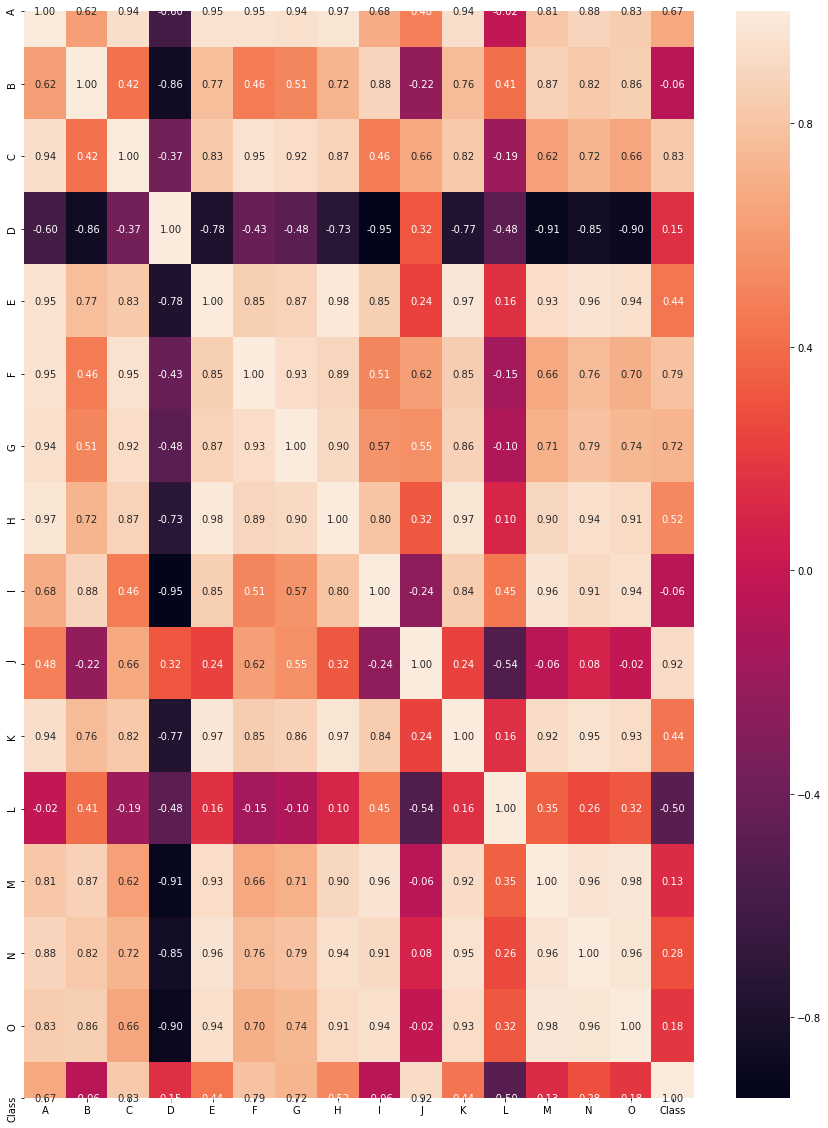

In [139]:
#https://stackoverflow.com/questions/56153726/plot-k-nearest-neighbor-graph-with-8-features

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt


def plot_correlation(data):
    '''
    plot correlation's matrix to explore dependency between features 
    '''
    # init figure size
    rcParams['figure.figsize'] = 15, 20
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()
    fig.savefig('corr.png')
plot_correlation(data_trained)

Just another way to visualize our coorelation data. Nothin here seems to stand out to me, just some that are pretty highly coordinated, but that does not mean that we have to drop them off. Additionally, my goal is to put them through a DBSCAN, not through feature selector or anything, but I was just checking.

In [17]:
data_transformed = StandardScaler().fit_transform(data_trained)
data_transformed

array([[-0.96356272, -0.19885159, -0.40350723, ..., -0.99028819,
        -0.81184795, -0.2422854 ],
       [ 1.20587068,  0.67284574,  1.55793605, ...,  1.17973579,
         0.74908012,  1.21289187],
       [-0.90385866, -0.92956091, -0.92321669, ..., -1.03006986,
        -0.84978588, -0.2422854 ],
       ...,
       [-1.01305266, -0.02764693, -0.6250014 , ..., -0.78216213,
        -1.13328857, -0.2422854 ],
       [ 1.24201975,  1.03074585,  1.19293769, ...,  1.12155873,
         0.90490043,  1.21289187],
       [-0.05091969,  1.19640229, -0.51829877, ...,  0.46592628,
         1.15648223, -1.69746267]])

In [18]:
#dbscan = DBSCAN(eps=3,min_samples=16)
#dbscan_model=dbscan.fit(data_transformed)

Doing a DBSCAN on my entire dataframe essentially kills my kernel...I guess there is not enough memory. So instead we will do the DBSCAN on a sample of the dataframe. 100,000 is relatively small for this data set...but DBSCAN still takes almost 15 minutes to complete on my machine. It is the best I could do with my machine.

In [19]:
data_trained_sample =data_trained.sample(100000)

In [20]:
data_transformed = StandardScaler().fit_transform(data_trained_sample)

In [21]:
dbscan = DBSCAN(eps=3,min_samples=16)
dbscan_trained = dbscan.fit(data_transformed)

In [22]:
labels_trained = dbscan_trained.labels_

In [23]:
labels_trained

array([0, 1, 1, ..., 0, 2, 0])

In [24]:
samples = np.zeros_like(labels_trained,dtype=bool)
samples[dbscan_trained.core_sample_indices_]=True
print(samples)

[ True  True  True ...  True  True  True]


In [25]:
clust = len(set(labels_trained)) - (1 if -1 in labels_trained else 0)
clust

3

Here we can see that the DBSCAN put them into 3 different clusters. We could have used more or less clusters, but from a paper that I read that the epsilon value (eps) should be based off of k-distance, but it was extremely difficult to find out the k-distance of 15 different items. I went with the default value of 3. The value of min_samples should be G or G + 1, where G is the number of features in the matrix (or dataframe), so I went with 15 + 1 = 16 for min_samples.

In [26]:
metrics.silhouette_score(data_trained_sample,labels_trained)

0.8124541130409509

The score is not bad, but I know that it is not that great because I do not know the exact k-distance value, and also due to the fact that I only have 100,000 samples, not the full value of the dataframe. Prior to putting each of our clusters through the pipeline, we should check to see what PCA we should use for the pipeline, for this I used the code from the provided example that Professor J gave us...also found here:https://districtdatalabs.silvrback.com/principal-component-analysis-with-python

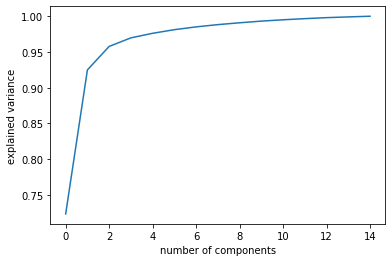

array([0.72348104, 0.20144964, 0.03286286, 0.01196537, 0.00637788,
       0.005072  , 0.00390537, 0.00316947, 0.00255662, 0.00234759,
       0.0018596 , 0.00158418, 0.00139875, 0.00103872, 0.00093091])

In [27]:
sc = StandardScaler()
df_scaled = sc.fit_transform(data.drop('Class', axis=1))
df_scaled = pd.DataFrame(df_scaled, columns=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O'])
df_scaled = pd.concat([df_scaled, data['Class']], axis=1)
pca_test = PCA(n_components=15)
pca_test.fit(df_scaled.drop('Class', axis=1))
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()
pca_test.explained_variance_ratio_

Looks like it is about 2...so I will use that as my PCA throughout this

Okay, we see coorelation, we have our DBSCAN of our trained data, lets add it to our dataframe!

In [127]:
data_trained_sample['Cluster']=labels_trained

In [128]:
data_trained_sample

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class,Cluster
116604,26.945324,-6.470211,26.483178,-3.891417,21.643998,10.793946,20.974694,25.373251,11.615126,15.068019,27.325523,-1.383503,-5.118993,18.646632,17.413165,3,0
526506,-16.141073,-13.458252,0.300161,5.865678,-15.283216,-19.697609,-3.128265,-20.363680,-10.683995,10.945306,-3.125577,-7.857119,-31.740838,-10.061166,-2.158226,2,1
916730,-29.217806,-8.514958,2.249491,0.839283,-17.219924,-15.361503,-5.386178,-17.682593,-7.467301,9.992724,-1.473415,-4.943880,-33.147387,-7.316697,-4.098721,2,1
638258,-22.206534,-10.999867,0.034024,4.441146,-17.060310,-19.034614,-1.694314,-16.495140,-9.035213,14.284326,-4.639407,-3.031613,-29.857460,-7.848076,-5.223585,2,1
827555,-14.550434,-11.317229,1.374953,3.175969,-18.468294,-15.665165,-7.031075,-18.366131,-9.361805,9.408533,-2.187939,-4.754769,-32.978082,-7.240741,-4.373255,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645787,35.841120,-4.382059,27.380570,-3.944148,16.060455,7.655254,15.673736,23.791337,12.939423,15.735817,26.185060,-1.853676,-8.103416,17.584768,21.337355,3,0
320202,-21.155629,-8.688901,-1.891097,3.831238,-13.110368,-17.858095,-8.735094,-17.392374,-8.065272,10.162004,-5.936574,-1.450735,-34.091157,-7.141515,-1.970914,2,1
610476,32.999391,-3.579606,32.348328,-4.342755,16.299246,10.488205,19.131245,28.509297,9.803668,14.979823,28.337654,-6.253967,-4.307916,21.484960,20.578144,3,0
655132,-2.462671,0.373353,1.635850,-11.745995,9.680664,-14.876775,0.714685,7.321614,21.759312,-6.957870,21.277001,2.522175,1.507569,18.646368,21.889379,1,2


Now we will remove each of the clusters and move them through the pipeline, figuring out which one has the best accuracy.

In [67]:
data_cluster0=data_trained_sample[data_trained_sample['Cluster']==0]

In [68]:
data_cluster0

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class,Cluster
116604,26.945324,-6.470211,26.483178,-3.891417,21.643998,10.793946,20.974694,25.373251,11.615126,15.068019,27.325523,-1.383503,-5.118993,18.646632,17.413165,3,0
925776,28.947651,-2.757345,28.447833,-5.253931,19.961878,7.868100,14.932624,31.657768,11.875287,20.027111,25.370868,-5.237457,-7.577118,20.894433,13.587067,3,0
313439,38.820387,-7.545867,24.875164,-4.984909,19.111798,12.679305,20.907423,28.975021,5.671367,13.012125,31.527212,-0.304318,-2.913030,24.001469,22.319407,3,0
996301,35.262844,-3.191399,28.810789,-4.050962,18.099659,13.488676,14.478975,26.265114,12.850086,14.208427,30.895562,-2.813250,-7.557161,16.061334,18.140404,3,0
1077307,31.951341,-3.024209,32.931290,-5.713732,17.803029,13.046986,20.637598,24.598034,10.138127,21.910933,36.018517,-4.176134,-3.710869,21.457484,24.917048,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39696,32.691482,-5.542750,32.432638,-6.390247,14.711295,7.186117,15.563570,27.982689,13.136952,14.251082,27.160401,-8.206537,-3.512720,16.379347,15.001268,3,0
249545,31.576942,-4.493741,32.417358,-4.120755,18.204547,10.370431,17.261423,24.760709,12.728904,13.212208,29.277547,-5.312173,-8.737137,18.063824,18.829226,3,0
645787,35.841120,-4.382059,27.380570,-3.944148,16.060455,7.655254,15.673736,23.791337,12.939423,15.735817,26.185060,-1.853676,-8.103416,17.584768,21.337355,3,0
610476,32.999391,-3.579606,32.348328,-4.342755,16.299246,10.488205,19.131245,28.509297,9.803668,14.979823,28.337654,-6.253967,-4.307916,21.484960,20.578144,3,0


In [94]:
from sklearn.ensemble import RandomForestClassifier

In [138]:
pipeline2 = PMMLPipeline([
 ('mapper',
 DataFrameMapper([
 (X_train.columns,
 [StandardScaler()])])),
 ('pca',
 PCA(n_components=2)),
 ('classifier',
     DecisionTreeClassifier())
])
pipeline2.fit(data_cluster0,
 data_cluster0['Class'])
results = pipeline2.predict(X_test)
actual = np.concatenate(y_test.values)
print('Accuracy:',metrics.accuracy_score(actual, results))

Accuracy: 0.33341666666666664


In [136]:
data_cluster1=data_trained_sample[data_trained_sample['Cluster']==1]

In [137]:
data_cluster1

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class,Cluster
526506,-16.141073,-13.458252,0.300161,5.865678,-15.283216,-19.697609,-3.128265,-20.363680,-10.683995,10.945306,-3.125577,-7.857119,-31.740838,-10.061166,-2.158226,2,1
916730,-29.217806,-8.514958,2.249491,0.839283,-17.219924,-15.361503,-5.386178,-17.682593,-7.467301,9.992724,-1.473415,-4.943880,-33.147387,-7.316697,-4.098721,2,1
638258,-22.206534,-10.999867,0.034024,4.441146,-17.060310,-19.034614,-1.694314,-16.495140,-9.035213,14.284326,-4.639407,-3.031613,-29.857460,-7.848076,-5.223585,2,1
827555,-14.550434,-11.317229,1.374953,3.175969,-18.468294,-15.665165,-7.031075,-18.366131,-9.361805,9.408533,-2.187939,-4.754769,-32.978082,-7.240741,-4.373255,2,1
461020,-23.089719,-8.685743,2.936370,2.715659,-13.506987,-19.284949,-3.904865,-16.488381,-6.185302,11.134456,-5.013280,-4.175846,-30.840813,-9.437113,-6.538247,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005857,-15.517641,-10.325456,5.821682,2.950714,-16.799936,-20.370690,-3.191230,-22.185361,-6.502132,2.279740,-6.355890,-8.386383,-32.462446,-9.165579,-8.987996,2,1
939138,-20.221506,-11.880865,1.259780,3.357637,-18.012602,-12.573982,-6.852003,-17.789214,-8.644721,9.206052,-2.173619,-3.555181,-32.350755,-8.984311,-3.143466,2,1
321623,-22.542615,-12.326318,2.189020,6.602672,-16.079522,-14.297530,-4.058247,-21.828417,-9.781503,12.118237,-8.269050,-1.555126,-33.283025,-6.654704,-5.008932,2,1
854066,-30.119310,-14.598690,1.569486,2.266884,-12.400066,-25.690747,-9.021994,-17.985636,-7.752834,6.588549,-6.172250,-3.470338,-33.982852,-5.258533,-3.517165,2,1


In [130]:
pipeline2.fit(data_cluster1,data_cluster1['Class'])
results = pipeline2.predict(X_test)
actual = np.concatenate(y_test.values)
print('Accuracy:',metrics.accuracy_score(actual, results))

Accuracy: 0.49908


In [132]:
data_cluster2=data_trained_sample[data_trained_sample['Cluster']==2]

In [133]:
data_cluster2

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class,Cluster
374952,-4.979038,-1.277031,1.358660,-15.840258,5.101695,-13.542803,-3.318072,5.123827,20.656444,-6.571713,18.083694,-0.219591,0.681729,20.935068,19.665099,1,2
396984,-2.869776,-4.049347,-0.328563,-9.892336,9.735780,-16.356732,0.057157,8.065254,22.992264,-6.424633,17.555469,-3.966988,-2.733179,18.187775,20.715164,1,2
1060061,-1.345317,-1.447880,3.806303,-18.047775,4.991108,-14.581525,-2.336385,12.179695,21.896931,-7.727957,14.921159,5.131211,-3.024651,18.737472,25.139933,1,2
215096,-3.220232,-4.381697,-0.467183,-8.213105,2.419153,-16.608398,-0.745495,6.065551,20.330901,-6.575169,20.431007,-0.194206,-0.555397,19.173892,23.747722,1,2
944636,-0.051902,-2.158652,0.441192,-16.593212,8.061397,-17.997530,-1.957670,7.658861,24.540556,-11.992860,22.191694,5.619629,-0.156018,19.062371,21.671440,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102402,-2.600204,-2.037030,1.325729,-12.644799,6.903072,-18.469729,-0.376434,14.205225,23.273744,-8.774968,14.170796,2.459198,1.951038,14.393022,23.089382,1,2
28404,-2.847861,-0.944027,0.034533,-11.292810,7.585624,-13.266073,-0.696730,8.109621,21.470030,-8.865766,21.103439,1.815817,3.680387,16.662590,20.195139,1,2
735263,-1.286388,2.902092,0.749394,-9.564385,8.135137,-12.380879,1.388631,7.373745,22.123836,-5.256108,21.814938,4.731945,-2.436472,19.549509,17.686241,1,2
411983,-3.780379,1.736153,0.383993,-10.779854,8.190682,-13.626526,2.023280,11.063610,20.710780,-10.000802,17.612857,-1.698441,1.086138,16.623417,21.743336,1,2


In [134]:
pipeline2.fit(data_cluster2,data_cluster2['Class'])
results = pipeline2.predict(X_test)
actual = np.concatenate(y_test.values)
print('Accuracy:',metrics.accuracy_score(actual, results))

Accuracy: 0.16750333333333334


# Final Pipeline

So...we can now see that the cluster with the highest accuracy (or really the most in the cluster) is Cluster 1. We will use that cluster for our final pipeline! I decided to go with a linear model SGD Regressor. This is because here: https://stackoverflow.com/questions/2595176/which-machine-learning-classifier-to-choose-in-general had a good image for which classifier should be used for what you want to look for, and I saw that a regressor would be the best. We are not predicting a category, we are predicting a quantity, and we have more than 100k samples, so we want to use regression on our data to classify it.

In [13]:
from sklearn import linear_model

final_pipe = Pipeline([
 ('scaler',StandardScaler()),
    ('clustering',DBSCAN(eps=3,min_samples=16)),
 ('pca',
 PCA(n_components=2)),
 ('classifier',
 linear_model.SGDRegressor())
 ])

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=16, n_jobs=None, p=None)' (type <class 'sklearn.cluster.dbscan_.DBSCAN'>) doesn't

In [157]:
final_pipe.fit(data_cluster1,data_cluster1['Class'])

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('classifier',
                 SGDRegressor(alpha=0.0001, average=False, early_stopping=False,
                              epsilon=0.1, eta0=0.01, fit_intercept=True,
                              l1_ratio=0.15, learning_rate='invscaling',
                              loss='squared_loss', max_iter=1000,
                              n_iter_no_change=5, penalty='l2', power_t=0.25,
                              random_state=None, shuffle=True, tol=0.001,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False))],
         verbose=False)

# Making the Onnx File
Hopefully I did this correctly, I used this code from the provided ones given to us with the project outline<br>
EDIT: Did not work for me, but I think it is something small

In [17]:
input_types = [('float_input', FloatTensorType([None, X_train.shape[1]]))]

try:
    model_onnx = convert_sklearn(final_pipe,
                                 'final_Diepholz_onnx',
                                initial_types=input_types)
except Exception as e:
    print(e)

with open("project_pipeline.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

name 'final_pipe' is not defined


NameError: name 'model_onnx' is not defined

In [12]:
inputs_onnx = {k: np.array(v).astype(np.float64)[:, np.newaxis] for k, v in X_test.to_dict(orient='list').items()}

session_onnx = rt.InferenceSession("project_pipeline.onnx")
predict_onnx = session_onnx.run(None, inputs_onnx)
print("predict", predict_onnx[0])

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : No graph was found in the protobuf.

# Conclusion

Overall, while my method seems simple and trivial, I believe it is extremely effective at clustering any data that it would have inputted, and should have an ok accuracy rate. The downside is that I could only sample 100,000 points, and I also could not calculate the k-distance in order to figure out the correct epsilon value. If I could continue with the project, I am sure I could be able to find a k-distance value over ALL of the data in order to find the correct epsilon value for the DBSCAN. Using that, I could get a more accurate value of all the clusters, and also make more clusters. Using more clusters, I could accurately separate them and create a pipeline that would correctly sort new data.

# Sources and Code Links

https://www.geeksforgeeks.org/implementing-dbscan-algorithm-using-sklearn/<br>
http://nebula.wsimg.com/b573f6daeaad3f38ead59a00eae13ffd?AccessKeyId=BDCFD2864AC62650B045&disposition=0&alloworigin=1<br>
https://medium.com/@elutins/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818<br>
https://github.com/jpmml/sklearn2pmml/blob/master/README.md<br>
https://www.bmc.com/blogs/create-machine-learning-pipeline/<br>
https://stackoverflow.com/questions/2595176/which-machine-learning-classifier-to-choose-in-general<br>
https://arxiv.org/pdf/1609.08520.pdf<br>
https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80<br>
https://www.sciencedirect.com/science/article/abs/pii/S0031320316001035<br>
https://medium.com/@elutins/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818<br>
https://thalis.math.upatras.gr/~vrahatis/papers/journals/PavlidisPTV06_OPER%20RES_INT_J_6_pp103-127_2006.pdf